Project Members: Anshika Gupta(ag8800), Mudassir Hussain (sh7420), Abhignya Bhat (ayb5037)

Comparing Residual Blocks

We aim to compare the performance of the models by tweaking the residual blocks.

First, we need to add all the packages:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import torch.backends.cudnn as cudnn
import sys
import time
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

Setting up the device to use cuda.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
valid_ratio = 0.9

Now we will do data augmentation using predetermined normalize parameters. We will then load training, test and valid dataset. We will also assign batch_size to the resnet iterator aka ..loader.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_data = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=128, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

n_train_examples = int(len(train_data) * valid_ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = transform_test

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=128, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=128, shuffle=False, num_workers=2)

valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=128, shuffle=False)

# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12800724.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = test_data.classes. #printing the test classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


The following funcion plots the images

In [ ]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

As a sample, we plot 25 images from the training data with labels.

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

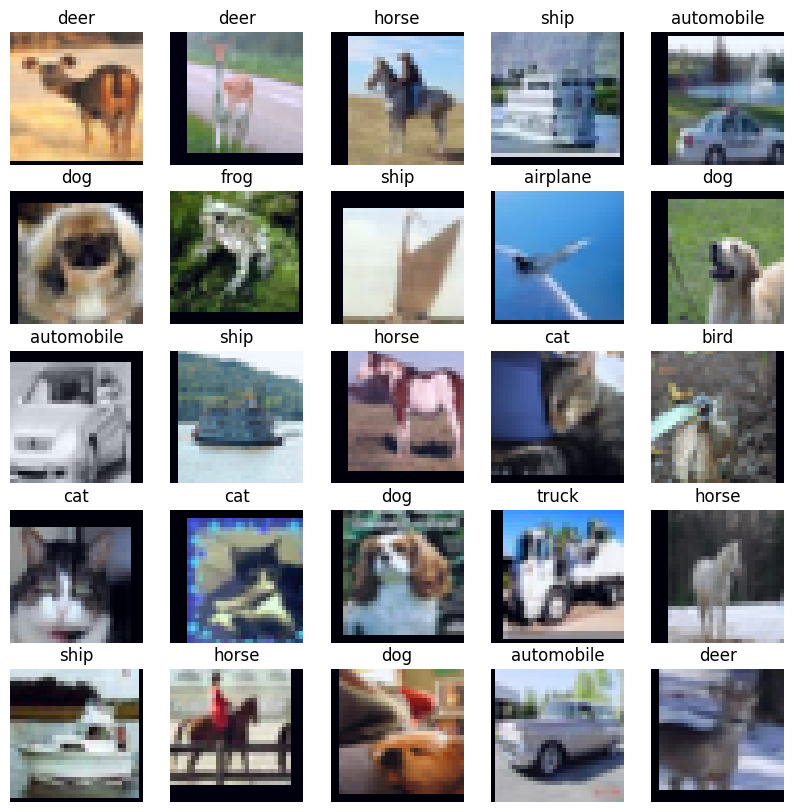

In [ ]:
plot_images(images, labels, classes, normalize = True)

## Building the Model

Ref: https://github.com/kuangliu/pytorch-cifar

We have used the above reference and made a few changes in the ResNet class so that we do not overshoot the parameters beyond 5 million.

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

As we can see, we have decided to go with 3 layers instead of 4.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self.x(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

## Model 1

Creating a method to initialize the ResNet18 model

In [ ]:
def ResNet18():
    return ResNet(BasicBlock, [3,2,3])

Inititalizing the model and loading it on to the device.

In [ ]:
model = ResNet18()
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

Here, we calculate the total number of parameters, and making sure we are not exceeding 5 million.

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters in the model: ", num_params)

Total number of parameters in the model:  4032330


Defining the optimizer, learning rate, momentum, and weight

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

To calculate accuracy between y_pred and target.

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Using some code snippets from ref https://github.com/kuangliu/pytorch-cifar. We will be using three different methods. One for training, another for testing and the last one for validating.

In [ ]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        acc = calculate_accuracy(y_pred, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += acc.item()
    return train_loss / len(train_loader), correct / len(train_loader)


In [ ]:
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)
            test_loss += loss.item()
            correct += acc.item()
    return test_loss / len(test_loader), correct / len(test_loader)

    # Save checkpoint.
    acc_temp = 100.*correct/total
    if acc_temp > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc_temp,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc_temp


In [ ]:
def validate(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)
            test_loss += loss.item()
            # _, predicted = outputs.max(1)
            # total += targets.size(0)
            correct += acc.item()
    return test_loss / len(valid_loader), correct / len(valid_loader)

Running the model for 75 epochs, we get:

In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc=[]
epoch = []

for e in range(start_epoch, start_epoch+75):
    train_epoch_loss, train_epoch_acc = train(e)
    vaild_epoch_loss, valid_epoch_acc = validate(e)
    test_epoch_loss, test_epoch_acc = test(e)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    train_acc.append(train_epoch_acc)
    test_acc.append(test_epoch_acc)
    epoch.append(e)
    print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train Acc: {train_epoch_acc*100:.3f}%')
    print(f'\t Val. Loss: {vaild_epoch_loss:.3f} |  Val. Acc: {valid_epoch_acc*100:.3f}%')


Epoch: 0
	Train Loss: 0.298 | Train Acc: 89.684%
	 Val. Loss: 0.549 |  Val. Acc: 83.340%

Epoch: 1
	Train Loss: 0.280 | Train Acc: 90.260%
	 Val. Loss: 0.492 |  Val. Acc: 84.805%

Epoch: 2
	Train Loss: 0.261 | Train Acc: 90.948%
	 Val. Loss: 0.452 |  Val. Acc: 85.996%

Epoch: 3
	Train Loss: 0.246 | Train Acc: 91.577%
	 Val. Loss: 0.512 |  Val. Acc: 85.000%

Epoch: 4
	Train Loss: 0.231 | Train Acc: 92.041%
	 Val. Loss: 0.514 |  Val. Acc: 85.195%

Epoch: 5
	Train Loss: 0.211 | Train Acc: 92.559%
	 Val. Loss: 0.447 |  Val. Acc: 85.957%

Epoch: 6
	Train Loss: 0.201 | Train Acc: 92.985%
	 Val. Loss: 0.654 |  Val. Acc: 82.695%

Epoch: 7
	Train Loss: 0.190 | Train Acc: 93.429%
	 Val. Loss: 0.406 |  Val. Acc: 87.656%

Epoch: 8
	Train Loss: 0.176 | Train Acc: 93.765%
	 Val. Loss: 0.464 |  Val. Acc: 86.191%

Epoch: 9
	Train Loss: 0.166 | Train Acc: 94.168%
	 Val. Loss: 0.462 |  Val. Acc: 86.855%

Epoch: 10
	Train Loss: 0.157 | Train Acc: 94.411%
	 Val. Loss: 0.436 |  Val. Acc: 87.266%

Epoch: 1

Now we plot the graph of Train loss vs Test loss

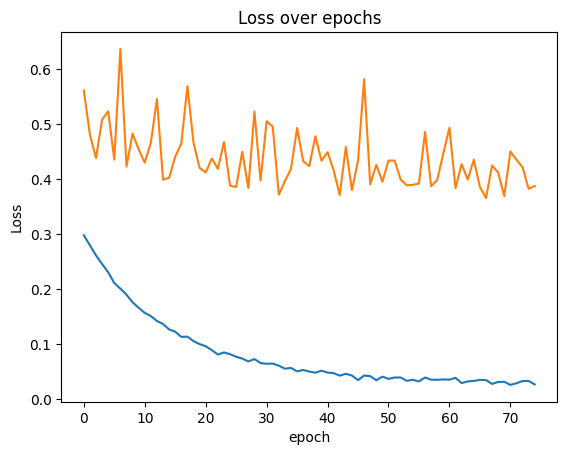

In [ ]:
plt.plot(epoch, train_loss, label="train loss")
plt.plot(epoch,test_loss, label="test loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.show()

Synonymously the curve of Accuracy follows an inversely proportional pattern from the loss graph shown above.

This piece of code has been taken from HW, and the following code cells are used to plot the confusion matrix.

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            labels.append(y)
            probs.append(y_pred)
            
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [ ]:
labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

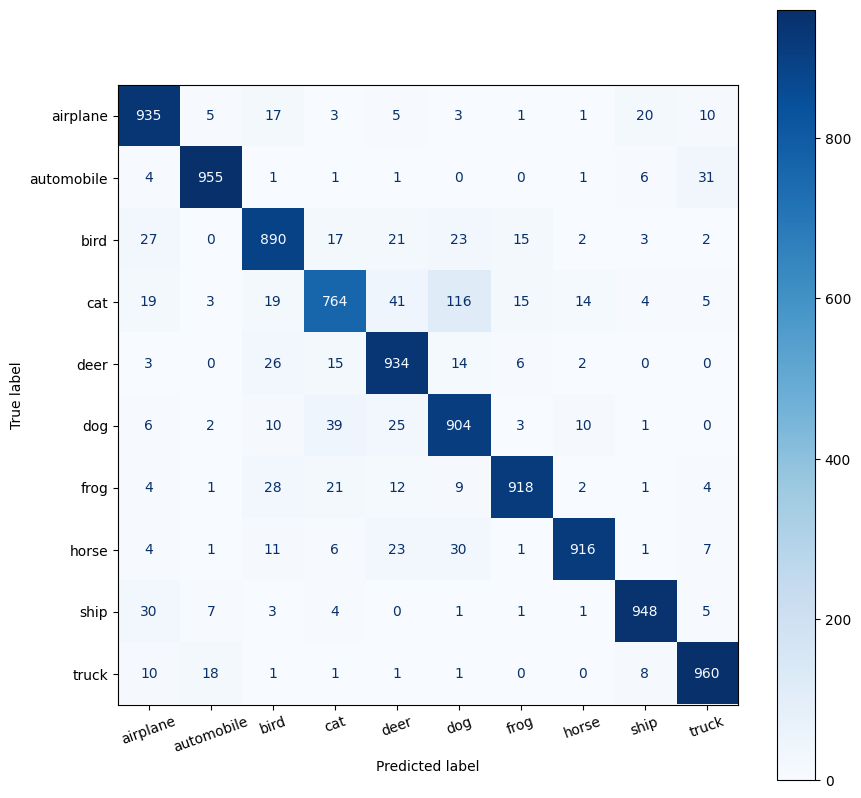

In [ ]:
labels = labels.to("cpu")
pred_labels = pred_labels.to("cpu")
plot_confusion_matrix(labels, pred_labels, classes) 

## Model 2

Similarly, Now we initialize a new model with residual block size of [4,3,3]

In [ ]:
def ResNet18_2():
    return ResNet(BasicBlock, [4,3,3])

In [ ]:
model = ResNet18_2()
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters in the model: ", num_params)

Total number of parameters in the model:  4401738


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        acc = calculate_accuracy(y_pred, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += acc.item()
    return train_loss / len(train_loader), correct / len(train_loader)


In [ ]:
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)
            test_loss += loss.item()
            correct += acc.item()
    return test_loss / len(test_loader), correct / len(test_loader)

    # Save checkpoint.
    acc_temp = 100.*correct/total
    if acc_temp > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc_temp,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc_temp


In [ ]:
def validate(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)
            test_loss += loss.item()
            # _, predicted = outputs.max(1)
            # total += targets.size(0)
            correct += acc.item()
    return test_loss / len(valid_loader), correct / len(valid_loader)

Foloowing similar steps as the previous model, we train this model for 75 epochs.

In [ ]:
train_loss_ = []
test_loss_ = []
train_acc_ = []
test_acc_ =[]
epoch_ = []

for e in range(start_epoch, start_epoch+75):
    train_epoch_loss, train_epoch_acc = train(e)
    vaild_epoch_loss, valid_epoch_acc = validate(e)
    test_epoch_loss, test_epoch_acc = test(e)
    train_loss_.append(train_epoch_loss)
    test_loss_.append(test_epoch_loss)
    train_acc_.append(train_epoch_acc)
    test_acc_.append(test_epoch_acc)
    epoch_.append(e)
    print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train Acc: {train_epoch_acc*100:.3f}%')
    print(f'\t Val. Loss: {vaild_epoch_loss:.3f} |  Val. Acc: {valid_epoch_acc*100:.3f}%')


Epoch: 0
	Train Loss: 1.259 | Train Acc: 54.287%
	 Val. Loss: 1.225 |  Val. Acc: 56.934%

Epoch: 1
	Train Loss: 0.885 | Train Acc: 68.888%
	 Val. Loss: 1.040 |  Val. Acc: 64.141%

Epoch: 2
	Train Loss: 0.694 | Train Acc: 75.838%
	 Val. Loss: 1.129 |  Val. Acc: 67.500%

Epoch: 3
	Train Loss: 0.587 | Train Acc: 79.633%
	 Val. Loss: 0.678 |  Val. Acc: 77.988%

Epoch: 4
	Train Loss: 0.512 | Train Acc: 82.241%
	 Val. Loss: 0.662 |  Val. Acc: 78.477%

Epoch: 5
	Train Loss: 0.456 | Train Acc: 84.089%
	 Val. Loss: 0.808 |  Val. Acc: 75.977%

Epoch: 6
	Train Loss: 0.416 | Train Acc: 85.677%
	 Val. Loss: 0.498 |  Val. Acc: 83.828%

Epoch: 7
	Train Loss: 0.379 | Train Acc: 86.829%
	 Val. Loss: 0.606 |  Val. Acc: 81.055%

Epoch: 8
	Train Loss: 0.345 | Train Acc: 88.218%
	 Val. Loss: 0.478 |  Val. Acc: 84.297%

Epoch: 9
	Train Loss: 0.323 | Train Acc: 88.793%
	 Val. Loss: 0.780 |  Val. Acc: 77.910%

Epoch: 10
	Train Loss: 0.299 | Train Acc: 89.566%
	 Val. Loss: 0.694 |  Val. Acc: 80.371%

Epoch: 1

Plotting the graph of Train Loss vs Test Loss, we obtain:

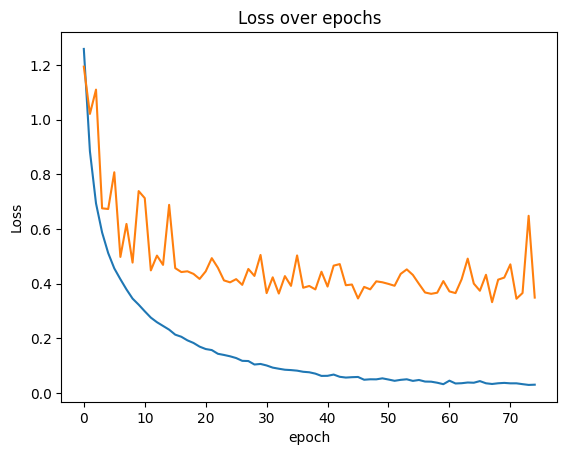

In [ ]:
plt.plot(epoch_, train_loss_, label="train loss")
plt.plot(epoch_,test_loss_, label="test loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.show()

With reference to the HW code, we plot the confusion matrix for the new model.

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            labels.append(y)
            probs.append(y_pred)
            
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [ ]:
labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

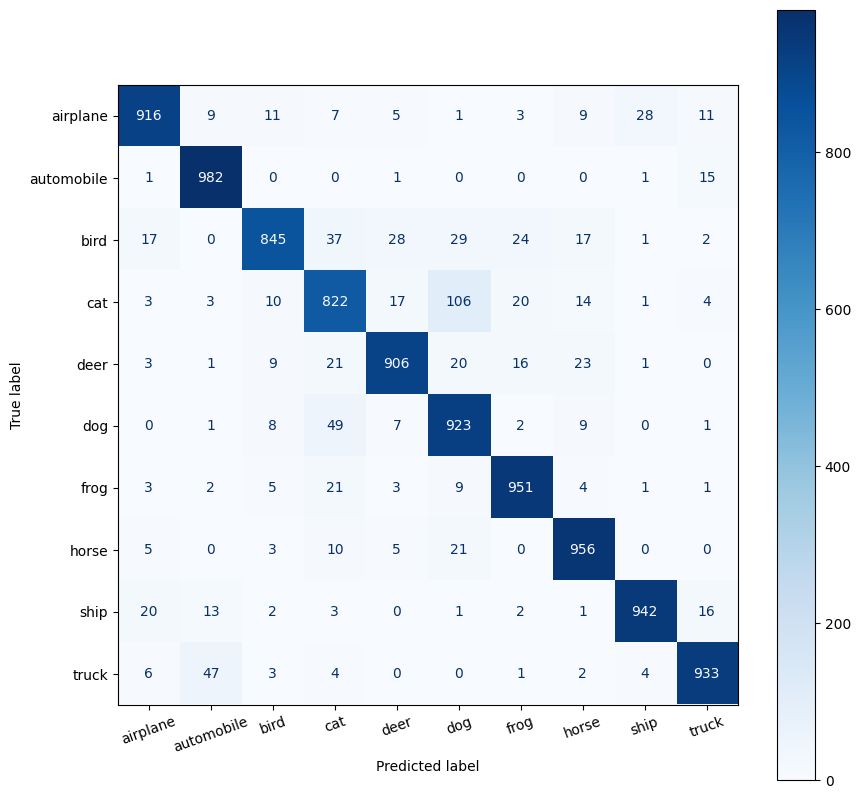

In [ ]:
labels = labels.to("cpu")
pred_labels = pred_labels.to("cpu")
plot_confusion_matrix(labels, pred_labels, classes) 